###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 parts of this notebook are from [this Jupyter notebook](https://nbviewer.jupyter.org/github/krischer/seismo_live/blob/master/notebooks/Computational%20Seismology/The Finite-Difference Method/fd_ac1d.ipynb) by Heiner Igel ([@heinerigel](https://github.com/heinerigel)), Lion Krischer ([@krischer](https://github.com/krischer)) and Taufiqurrahman ([@git-taufiqurrahman](https://github.com/git-taufiqurrahman)) which is a supplemenatry material to the book [Computational Seismology: A Practical Introduction](http://www.computational-seismology.org/),  additional modifications by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# From 1D to 2D acoustic finite difference modelling

The 1D acoustic wave equation is very useful to introduce the general concept and problems related to FD modelling. However, for realistic modelling and seismic imaging/inversion applications we have to solve at least the 2D acoustic wave equation.

In the class we will develop a 2D acoustic FD modelling code based on the 1D code. I strongly recommend that you do this step by yourself, starting from this notebook containing only the [1D code](https://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/05_2D_acoustic_FD_modelling/lecture_notebooks/1_From_1D_to_2D_acoustic_FD_modelling.ipynb). 

## Finite difference solution of 2D acoustic wave equation

As derived in [this](https://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/01_Analytical_solutions/3_Acoustic_medium.ipynb) and [this lecture](https://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/01_Analytical_solutions/4_2D_1D_elastic_acoustic_approx.ipynb), the acoustic wave equation in 2D with constant density is

\begin{equation}
\frac{\partial^2 p(x,z,t)}{\partial t^2} \ = \ vp(x,z)^2 \biggl(\frac{\partial^2 p(x,z,t)}{\partial x^2}+\frac{\partial^2 p(x,z,t)}{\partial z^2}\biggr) + f(x,z,t) \nonumber
\end{equation}

with pressure $p$, acoustic velocity $vp$ and source term $f$. We can split the source term into a spatial and temporal part. Spatially, we assume that the source is localized at one point ($x_s, z_s$). Therefore, the spatial source contribution consists of two Dirac $\delta$-functions $\delta(x-x_s)$ and $\delta(z-z_s)$. The temporal source part is an arbitrary source wavelet $s(t)$:

\begin{equation}
\frac{\partial^2 p(x,z,t)}{\partial t^2} \ = \ vp(x,z)^2 \biggl(\frac{\partial^2 p(x,z,t)}{\partial x^2}+\frac{\partial^2 p(x,z,t)}{\partial z^2}\biggr) + \delta(x-x_s)\delta(z-z_s)s(t) \nonumber
\end{equation}

Both second derivatives can be approximated by a 3-point difference formula. For example for the time derivative, we get:

\begin{equation}
\frac{\partial^2 p(x,z,t)}{\partial t^2} \ \approx \ \frac{p(x,z,t+dt) - 2 p(x,z,t) + p(x,z,t-dt)}{dt^2}, \nonumber
\end{equation}

and similar for the spatial derivatives: 

\begin{equation}
\frac{\partial^2 p(x,z,t)}{\partial x^2} \ \approx \ \frac{p(x+dx,z,t) - 2 p(x,z,t) + p(x-dx,z,t)}{dx^2}, \nonumber
\end{equation}

\begin{equation}
\frac{\partial^2 p(x,z,t)}{\partial x^2} \ \approx \ \frac{p(x,z+dz,t) - 2 p(x,z,t) + p(x,z-dz,t)}{dz^2}, \nonumber
\end{equation}

Injecting these approximations into the wave equation allows us to formulate the pressure p(x) for the time step $t+dt$ (the future) as a function of the pressure at time $t$ (now) and $t-dt$ (the past). This is called an **explicit time integration scheme** allowing the $extrapolation$  of the space-dependent field into the future only looking at the nearest neighbourhood.

In the next step, we discretize the P-wave velocity and pressure wavefield at the discrete spatial grid points 

\begin{align}
x &= i*dx\nonumber\\
z &= j*dz\nonumber\\
\end{align}

with $i = 0, 1, 2, ..., nx$, $j = 0, 1, 2, ..., nz$ on a 2D Cartesian grid.

<img src="images/2D-grid_cart_ac.png" width="75%">

Using the discrete time steps

\begin{align}
t &= n*dt\nonumber
\end{align}

with $n = 0, 1, 2, ..., nt$ and time step $dt$, we can replace the time-dependent part (upper index time, lower indices space) by

\begin{equation}
 \frac{p_{i,j}^{n+1} - 2 p_{i,j}^n + p_{i,j}^{n-1}}{\mathrm{d}t^2} \ = \ vp_{i,j}^2 \biggl( \frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial z^2}\biggr) \ + \frac{s_{i,j}^n}{dx\;dz}. \nonumber
\end{equation}

The spatial $\delta$-functions $\delta(x-x_s)$ and $\delta(z-z_s)$ in the source term are approximated by the boxcar function:

$$
\delta_{bc}(x) = \left\{
\begin{array}{ll}
	1/dx &|x|\leq dx/2 \\
	0 &\text{elsewhere} 	
\end{array}
\right.
$$

Solving for $p_{i,j}^{n+1}$ leads to the extrapolation scheme:

\begin{equation}
p_{i,j}^{n+1} \ = \ vp_{i,j}^2 \mathrm{d}t^2 \left( \frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial z^2} \right) + 2p_{i,j}^n - p_{i,j}^{n-1} + \frac{\mathrm{d}t^2}{dx\; dz} s_{i,j}^n.
\end{equation}

The spatial derivatives are determined by 

\begin{equation}
\frac{\partial^2 p(x,z,t)}{\partial x^2} \ \approx \ \frac{p_{i+1,j}^{n} - 2 p_{i,j}^n + p_{i-1,j}^{n}}{\mathrm{d}x^2} \nonumber
\end{equation}

and

\begin{equation}
\frac{\partial^2 p(x,z,t)}{\partial z^2} \ \approx \ \frac{p_{i,j+1}^{n} - 2 p_{i,j}^n + p_{i,j-1}^{n}}{\mathrm{d}z^2}. \nonumber
\end{equation}

Eq. (1) is the essential core of the 2D FD modelling code. Because we derived analytical solutions for wave propagation in a homogeneous medium, we should test our first code implementation for a similar medium, by setting

\begin{equation}
vp_{i,j} = vp0\notag
\end{equation}

at each spatial grid point $i = 0, 1, 2, ..., nx$; $j = 0, 1, 2, ..., nz$, in order to compare the numerical with the analytical solution. For a complete description of the problem we also have to define initial and boundary conditions. The **initial condition** is 

\begin{equation}
p_{i,j}^0 = 0, \nonumber
\end{equation}

so the modelling starts with zero pressure amplitude at each spatial grid point $i, j$. As **boundary conditions**, we assume 

\begin{align}
p_{0,j}^n = 0, \nonumber\\
p_{nx,j}^n = 0, \nonumber\\
p_{i,0}^n = 0, \nonumber\\
p_{i,nz}^n = 0, \nonumber
\end{align}

for all time steps n. This **Dirichlet boundary condition**, leads to artifical boundary reflections which would obviously not describe a homogeneous medium. For now, we simply extend the model, so that boundary reflections are not recorded at the receiver positions.

Let's implement it ...

In [2]:
# Import Libraries 
# ----------------
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Definition of modelling parameters
# ----------------------------------
xmax = 500.0 # maximum spatial extension of the 1D model in x-direction (m)
zmax = xmax  # maximum spatial extension of the 1D model in z-direction(m)
dx   = 1.0   # grid point distance in x-direction
dz   = dx    # grid point distance in z-direction

tmax = 0.502   # maximum recording time of the seismogram (s)
dt   = 0.0010  # time step

vp0  = 580.   # P-wave speed in medium (m/s)

# acquisition geometry
xr = 330.0 # x-receiver position (m)
zr = xr    # z-receiver position (m)

xsrc = 250.0 # x-source position (m)
zsrc = 250.0 # z-source position (m)

f0   = 40. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift (s)

## Comparison of 2D finite difference with analytical solution

In the function below we solve the homogeneous 2D acoustic wave equation by the 3-point spatial/temporal difference operator and compare the numerical results with the analytical solution: 

\begin{equation}
G_{analy}(x,z,t) = G_{2D} * S \nonumber 
\end{equation}

with the 2D Green's function:

\begin{equation}
G_{2D}(x,z,t) = \dfrac{1}{2\pi V_{p0}^2}\dfrac{H\biggl((t-t_s)-\dfrac{|r|}{V_{p0}}\biggr)}{\sqrt{(t-t_s)^2-\dfrac{r^2}{V_{p0}^2}}}, \nonumber 
\end{equation}

where $H$ denotes the Heaviside function, $r = \sqrt{(x-x_s)^2+(z-z_s)^2}$ the source-receiver distance (offset) and $S$ the source wavelet.

To play a little bit more with the modelling parameters, I restricted the input parameters to dt and dx. The number of spatial grid points and time steps, as well as the discrete source and receiver positions are estimated within this function.

In [4]:
# 2D Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------
def FD_2D_acoustic(dt,dx,dz):
        
    nx = (int)(xmax/dx) # number of grid points in x-direction
    print('nx = ',nx)
    
    nz = (int)(zmax/dz) # number of grid points in x-direction
    print('nz = ',nz)
            
    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)
    
    ir = (int)(xr/dx)      # receiver location in grid in x-direction    
    jr = (int)(zr/dz)      # receiver location in grid in z-direction
    
    isrc = (int)(xsrc/dx)  # source location in grid in x-direction
    jsrc = (int)(zsrc/dz)  # source location in grid in x-direction

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of a Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))

    # Analytical solution
    # -------------------
    G    = time * 0.

    # Initialize coordinates
    # ----------------------
    x    = np.arange(nx)
    x    = x * dx       # coordinates in x-direction (m)

    z    = np.arange(nz)
    z    = z * dz       # coordinates in z-direction (m)
    
    # calculate source-receiver distance
    r = np.sqrt((x[ir] - x[isrc])**2 + (z[jr] - z[jsrc])**2)
    
    for it in range(nt): # Calculate Green's function (Heaviside function)
        if (time[it] - r / vp0) >= 0:
            G[it] = 1. / (2 * np.pi * vp0**2) * (1. / np.sqrt(time[it]**2 - (r/vp0)**2))
    Gc   = np.convolve(G, src * dt)
    Gc   = Gc[0:nt]
    lim  = Gc.max() # get limit value from the maximum amplitude
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p

    # Initialize model (assume homogeneous model)
    # -------------------------------------------
    vp    = np.zeros((nx,nz))
    vp    = vp + vp0       # initialize wave velocity in model

    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt) 
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):
    
        # FD approximation of spatial derivative by 3 point operator
        for i in range(1, nx - 1):
            for j in range(1, nz - 1):
                
                d2px[i,j] = (p[i + 1,j] - 2 * p[i,j] + p[i - 1,j]) / dx ** 2                
                d2pz[i,j] = (p[i,j + 1] - 2 * p[i,j] + p[i,j - 1]) / dz ** 2

        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp ** 2 * dt ** 2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
                
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # Output of Seismogram
        # -----------------
        seis[it] = p[ir,jr]   
        
    # Compare FD Seismogram with analytical solution
    # ---------------------------------------------- 
    # Define figure size
    rcParams['figure.figsize'] = 12, 5
    plt.plot(time, seis, 'b-',lw=3,label="FD solution") # plot FD seismogram
    Analy_seis = plt.plot(time,Gc,'r--',lw=3,label="Analytical solution") # plot analytical solution
    plt.xlim(time[0], time[-1])
    plt.ylim(-lim, lim)
    plt.title('Seismogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()            

nx =  500
nz =  500
nt =  502


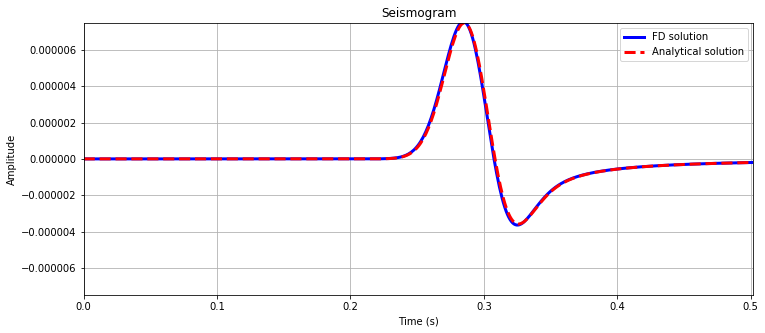

CPU times: user 3min 6s, sys: 540 ms, total: 3min 6s
Wall time: 3min 6s


In [5]:
%%time
dx   = 1.0     # grid point distance in x-direction (m)
dx   = dz      # grid point distance in z-direction (m)
dt   = 0.0010  # time step (s)
FD_2D_acoustic(dt,dx,dz)

OK, the 2D acoustic modelling code seem to run correctly. Despite some small numerical dispersion, the match between the analytical and numerical solution is quite accurate. However, with a runtime of roughly 3 minutes there is some room for performance optimization, which we will cover in the next lecture ...

## What we learned:

* It is easy to develop a 2D acoustic FD modelling code based on an existing 1D code
* The runtime of the sloppy implementation is a little bit underwhelming, so we have to consider some performance optimizations